## Make a simple synthetic dataset to test hierarchical merge in FOF algorithm

#### the idea is this: 

* after the local FOF stage, each partition reports the particles it holds in the overlap region
* do a reduceByKey or treeAggregate of some sort to collect the groups belonging to the same particles
* produce a mapping of $G -> G_1$ and distribute to all hosts in form of broadcast lookup table

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.setrecursionlimit(sys.getrecursionlimit()*10)

import matplotlib.patches as patches

/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:486: UserWarning: matplotlibrc text.usetex option can not be used unless TeX-3.1415 or later is installed on your system
  'installed on your system') % tex_req)
/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:493: UserWarning: matplotlibrc text.usetex can not be used with *Agg backend unless dvipng-1.5 or later is installed on your system
  warnings.warn('matplotlibrc text.usetex can not be used with *Agg '
/Users/rokstar/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:508: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-7.07 or later is installed on your system
  'installed on your system') % gs_req)


In [2]:
import spark_fof

In [3]:
def plot_rectangle(rec, ax=None):
    if ax is None: 
        ax = plt.subplot(aspect='equal')
    
    if isinstance(rec, (list, tuple)):
        for r in rec: 
            plot_rectangle(r,ax)
    
    else:
        size = (rec.maxes-rec.mins)
        ax.add_patch(patches.Rectangle(rec.mins, size[0], size[1], fill=False, zorder=-1))
    
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1)

In [4]:
import spark_fof_c

## Set up data

In [5]:
import numpy as np

import matplotlib.pylab as plt

%matplotlib inline

import fof

In [6]:
# create the arrays
pdt = np.dtype([('pos','f4', 3), ('iGroup', 'i4'), ('iOrder', 'i4')])
nps = 10000
ngs = 5
particles = np.zeros(nps, dtype=pdt)
done_ps = 0
centers = np.random.rand(ngs,3)*1.7 - 0.85
for group, center in zip(range(ngs), centers): 
    group_ps = nps/ngs
    if nps - (done_ps + group_ps) < group_ps:
        group_ps = nps - done_ps 
    particles['pos'][done_ps:done_ps+group_ps] = \
        np.random.multivariate_normal(center, [[.001,0,0],[0,.001,0],[0,0,.001]], group_ps)
    done_ps += group_ps
   
particles['iOrder'] = range(nps)

## Start Spark

In [7]:
import findspark
findspark.init()

In [8]:
import os
os.environ['SPARK_CONF_DIR'] = './conf'

In [9]:
import pyspark
from pyspark import SparkContext, SparkConf

In [10]:
conf = SparkConf()

In [11]:
conf.set('spark.python.profile', 'true')
conf.set('spark.executor.memory', '5G')
conf.set('spark.driver.memory', '4G')


In [12]:
sc = SparkContext(master='local[4]', conf=conf, batchSize=0)

In [13]:
sc.addPyFile('spark_fof.py')

## Set up the domains

In [14]:
N = 4
tau = 0.1
mins = np.array([-1,-1,-1], dtype=np.float)
maxs= np.array([1,1,1], dtype=np.float)
domain_containers = spark_fof.setup_domain(N,tau,maxs,mins)

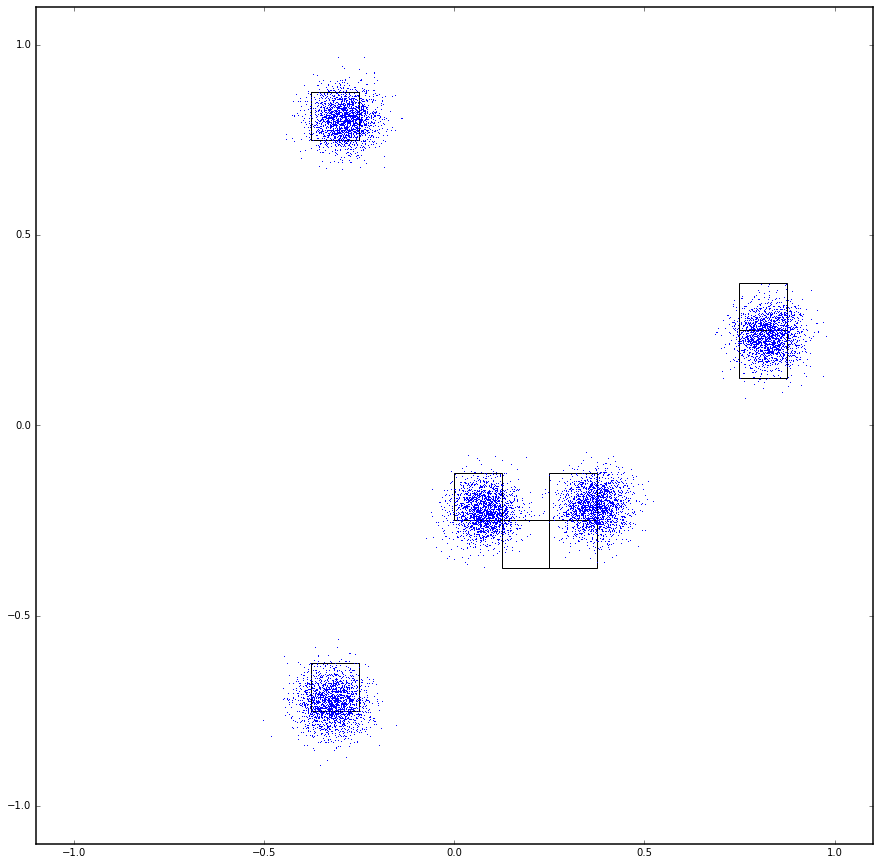

In [39]:
f, ax = plt.subplots(subplot_kw={'aspect':'equal'}, figsize=(15,15))
#plot_rectangle(domain_containers[0].bufferRectangle, ax=ax)
for p in particles[::1000]: 
    plot_rectangle(domain_containers[spark_fof.get_bin_cython(p['pos'],2**N, np.array(mins), np.array(maxs))], ax=ax)
#    plot_rectangle(domain_containers[get_bin(p.x, p.y, 2**N, mins,maxes)].bufferRectangle, ax=ax)
# for r in domain_containers: 
#     plot_rectangle(r.parent, ax=ax)
ax.plot(particles['pos'][:,0], particles['pos'][:,1], ',')

### Make the base RDD

In [16]:
p_rdd = sc.parallelize(particles)

### Partition particles into domains and set the partition part of local group ID

In [17]:
# partitioning duplicates the particles that are located in the boundary regions
part_rdd = (p_rdd.mapPartitions(lambda particles: spark_fof.partition_particles_cython(particles, domain_containers, tau))
                 .partitionBy(len(domain_containers))
                 .values())

### Run the local FOF

In [18]:
from spark_util import spark_cython

In [19]:
run_fof = spark_cython('fof', 'run')

In [20]:
def run_local_fof(index, particle_iter, tau): 
    part_arr = np.fromiter(particle_iter, pdt)
    if len(part_arr)>0:
        run_fof(part_arr, tau)
    return part_arr

def set_group_id(partition_index, particle_iter):
    part_arr = np.fromiter(particle_iter, pdt)
    for i in range(len(part_arr)):
        gid = part_arr[i]['iGroup']
        part_arr[i]['iGroup'] = spark_fof.encode_gid(partition_index, gid, 16)
    return part_arr

In [21]:
fof_rdd = part_rdd.mapPartitionsWithIndex(lambda index, particles: run_local_fof(index, particles, tau))\
                  .mapPartitionsWithIndex(set_group_id).cache()

### Group Merging stage

In [22]:
fof_analyzer = spark_fof.FOFAnalyzer(sc, N, tau, fof_rdd)

In [23]:
merged_rdd = fof_analyzer.merge_groups(0)

In [24]:
merged = merged_rdd.collect()

In [25]:
merged_arr = np.fromiter(merged, pdt)

In [26]:
groups = np.unique(merged_arr['iGroup'])

In [27]:
groups

array([ 38207488,  41746432, 164888576, 190447616, 201523200, 208142336], dtype=int32)

38207488 10519
41746432 10366
164888576 10392
190447616 10267
201523200 10608
208142336 7


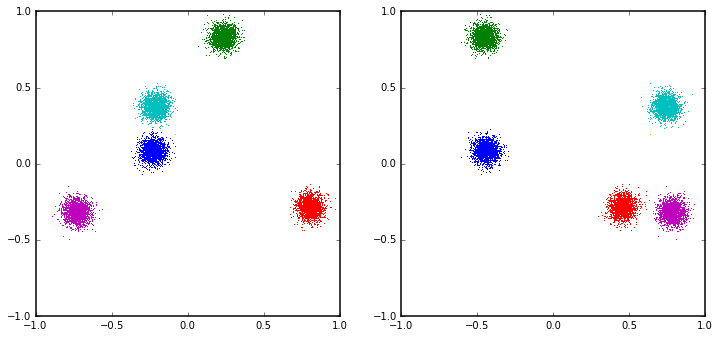

In [38]:
f, axs = plt.subplots(1,2, subplot_kw={'aspect':'equal'}, figsize=(12,12))
for group in groups: 
    inds = np.where(merged_arr['iGroup'] == group)[0]
    print group, len(inds)
    axs[0].plot(merged_arr['pos'][inds,1], merged_arr['pos'][inds,0], ',')
    axs[1].plot(merged_arr['pos'][inds,2], merged_arr['pos'][inds,0], ',')
for ax in axs:
    ax.set_xlim(-1,1); ax.set_ylim(-1,1)

In [35]:
domain_containers[0]

<DomainRectangle [(-1.0, -0.875), (-1.0, -0.875), (-1.0, -0.875)]>

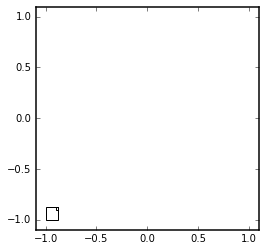

In [30]:
ax = plt.subplot(aspect='equal')
plot_rectangle(domain_containers[0], ax=ax)
plot_rectangle(domain_containers[0].bufferRectangle, ax=ax)